In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from cupyx.scipy.sparse import csc_matrix
import cupy as cp
from scipy.linalg import expm
from ipynb_util import *
from lightprop2d import Beam2D, random_round_hole_phase, um, round_hole, gaussian_beam, plane_wave

In [2]:
bounds = [-4.5 * 3.5 / 2, 4.5 * 3.5 / 2]
modes_indices = np.arange(-11, 0, 1)

In [3]:
modes, betas, ops = load_fiber_data('mmf_GRIN_62.5_*.npz')

Распределения интенсивности 10 старших мод для прямого волокна

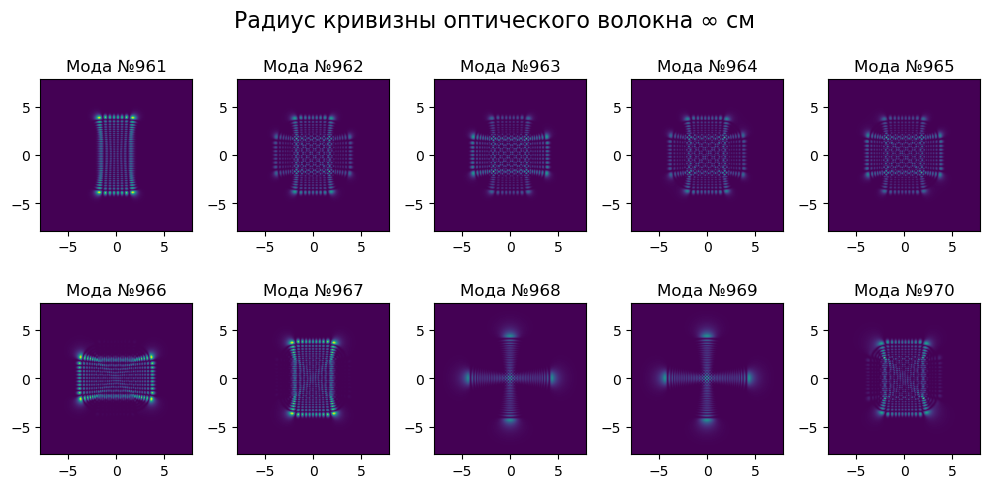

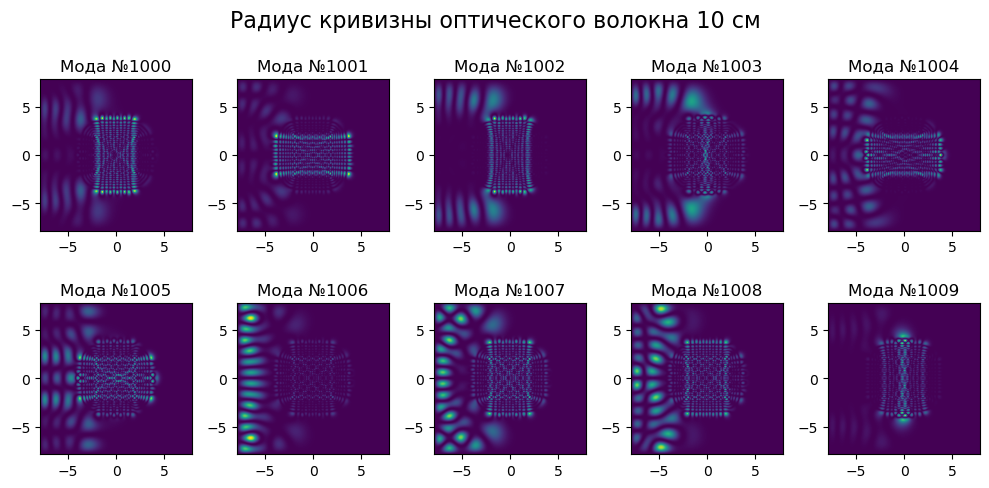

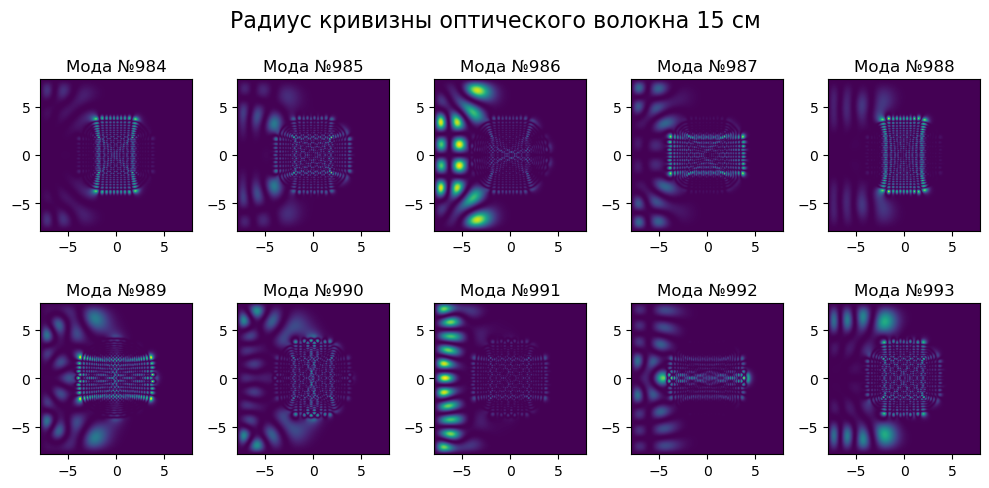

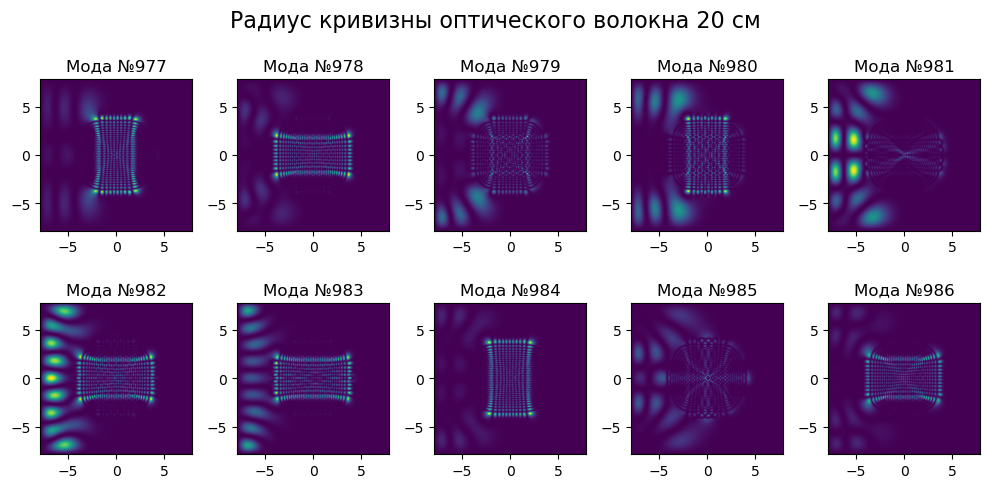

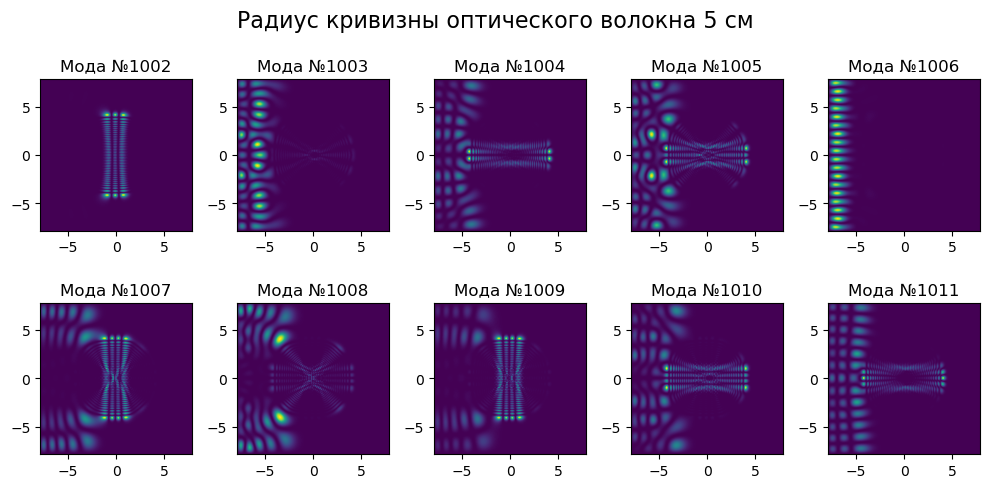

In [4]:
for c in modes:
    plot_modes(modes[c], modes_indices, bounds, c)

Распределения интенсивности 10 старших мод для волокна с радиусом кривизны $R=15$ см

Распределения интенсивности 10 старших мод для волокна с радиусом кривизны $R=10$ см

Распределения интенсивности 10 старших мод для волокна с радиусом кривизны $R=5$ см

### Корреляция между модами прямого волокна и модами изогнутых волокон

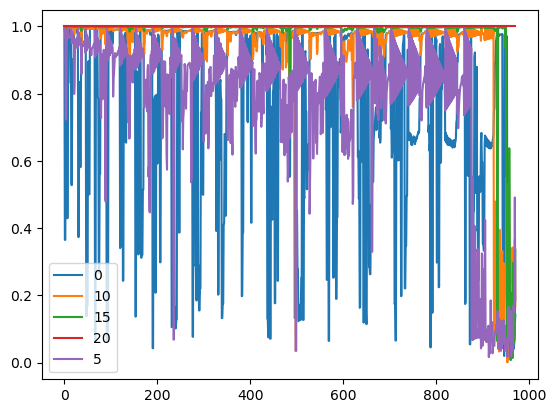

In [7]:
diff = {}
for k in modes:
    diff[k] = []
    for i in range(len(modes[0])):
        diff[k].append(np.abs(cp.corrcoef(cp.abs(modes[20][i].flatten()) ** 2, cp.abs(modes[k][i].flatten()) ** 2)[0, 1].get()))
    plt.plot(diff[k], label=k)
plt.legend()

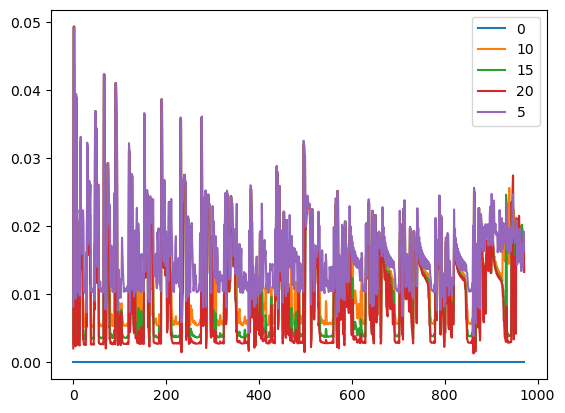

In [8]:
for k in modes:
    diff = []
    for i in range(len(modes[0])):
        diff.append(cp.linalg.norm(modes[0][i] ** 2 - modes[k][i] ** 2).get())
    plt.plot(diff, label=k)
plt.legend()

### Изменение спекл-структуры в зависимости от радиуса кривизны волокна

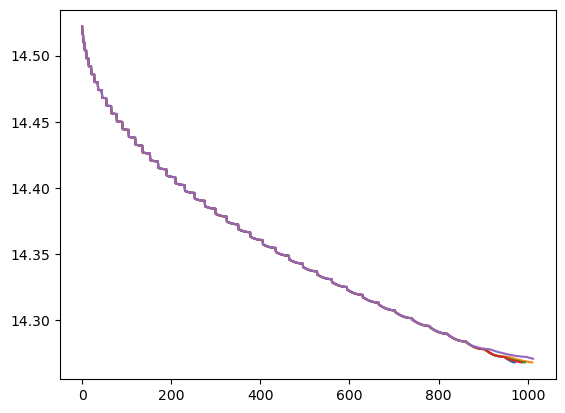

In [9]:
for c in betas:
    plt.plot(np.abs(betas[c]))    
    # plt.plot(np.imag(betas[c]))

In [5]:
wl = 0.632  # wavelength in microns
radius = 31.25  # in microns
n1 = 1.45

# calculate the field on an area larger than the diameter of the fiber
area_size = 3.5 * radius
npoints = 2**8  # resolution of the window
fiber_len = 100 / um

ref = Beam2D(area_size, npoints, wl,
             init_field_gen=random_round_hole_phase,
             init_gen_args=(radius,), use_gpu=True,
             complex_bits=64)

random_hole_data = {}
for c in modes:
    random_hole_data[c] = calc_inout(modes[c], ops[c], ref, fiber_len)

c:\Users\vonGostev\miniconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


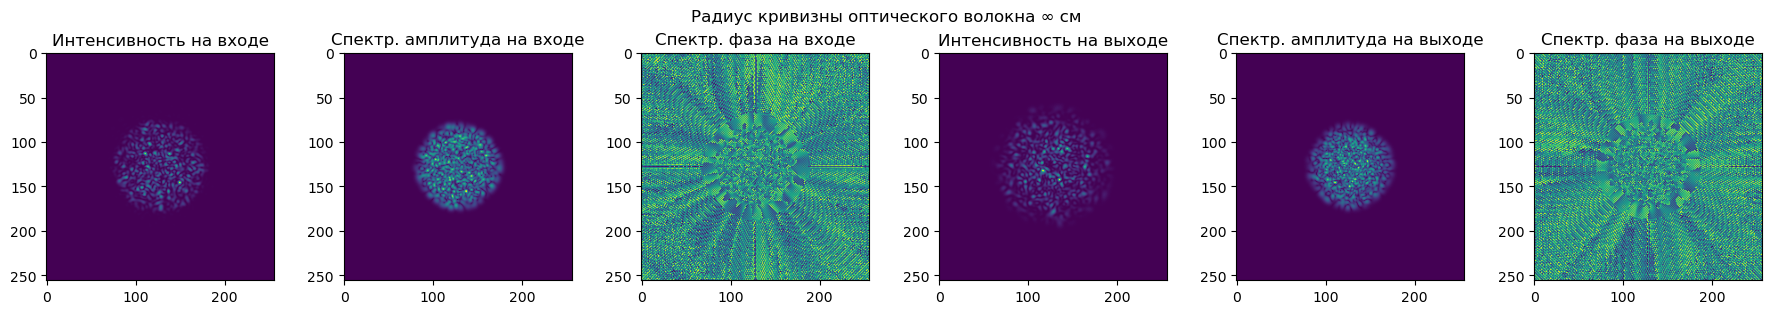

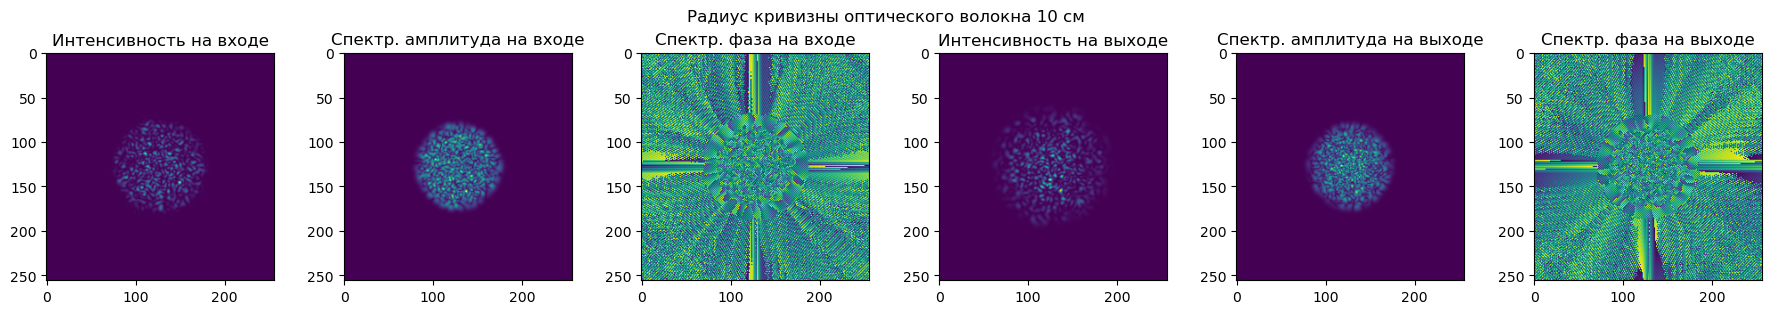

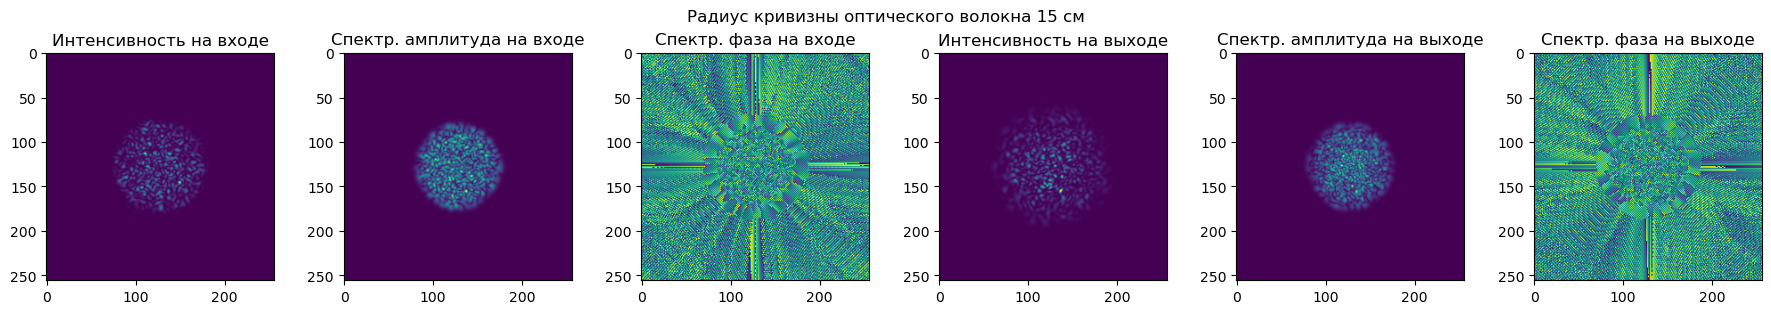

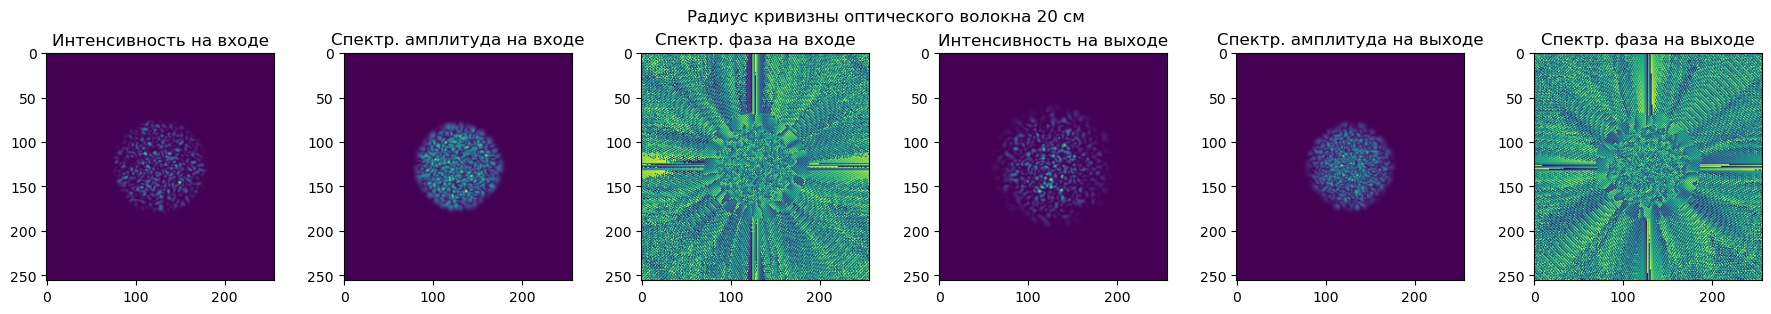

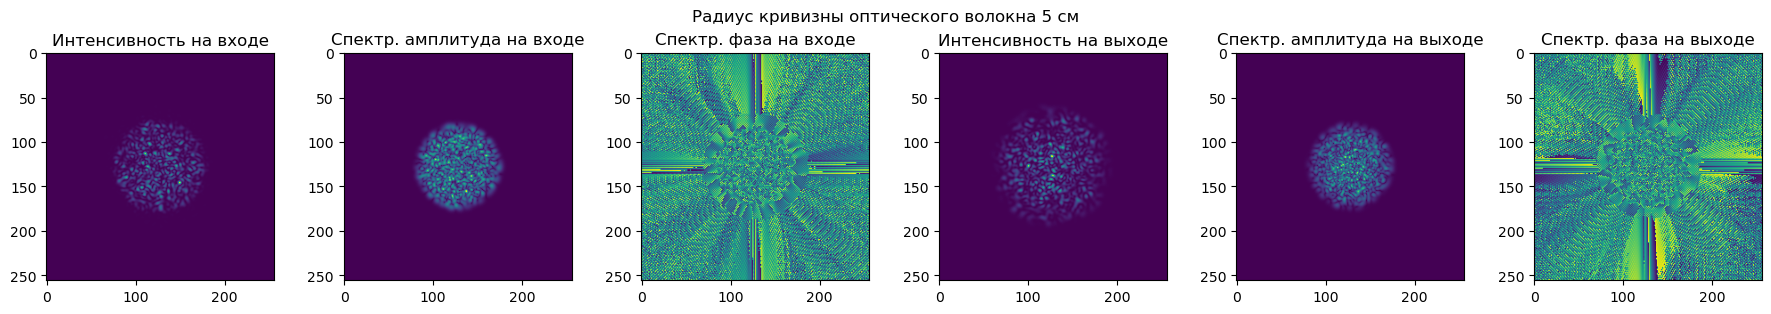

In [6]:
for c in random_hole_data:
    plot_inout_data(random_hole_data[c], c)

In [12]:
for c, data in random_hole_data.items():
    i = cp.abs(data[0]).get().flatten() ** 2
    o = cp.abs(data[2]).get().flatten() ** 2
    print(np.corrcoef(i, o)[0,1])

0.4602256134679022
0.4513631065117102
0.4539646419268685
0.4563987539929979
0.46756926979444147


In [13]:
for c, data in random_hole_data.items():
    i = cp.abs(random_hole_data[20][2]).get().flatten() ** 2
    o = cp.abs(data[2]).get().flatten() ** 2
    print(np.corrcoef(i, o)[0,1])

0.4530072887243649
0.8206256065409593
0.8693331888260772
1.0
0.6073195911844023


### Reflection test

In [14]:
from lightprop2d import gaussian_beam

wl = 0.632  # wavelength in microns
radius = 31.25  # in microns
n1 = 1.45
N = 100
# calculate the field on an area larger than the diameter of the fiber
area_size = 3.5 * radius
npoints = 2**8  # resolution of the window

ref = Beam2D(area_size, npoints, wl,
             init_field_gen=gaussian_beam,
             init_gen_args=(1, radius / 2,), use_gpu=True,
             complex_bits=64)

inputs = {}
outputs = {}
doutputs = {}
modes_sets = {}
for c in modes:
    idx = len(modes[c])
    test = Beam2D(area_size, npoints, wl, init_field=ref.field.copy(),
                  init_spectrum=ref.spectrum.copy(), use_gpu=True,
                  complex_bits=64)
    _modes = modes[c][:idx]
    modes_matrix = np.vstack(_modes).T
    modes_matrix_t = modes_matrix.T
    modes_matrix_dot_t = modes_matrix.T.dot(modes_matrix)
    fiber_len = 100 / um
    fiber_matrix = csc_matrix(expm(1j * ops[c] * fiber_len))[:idx, :idx]

    m = test.fast_deconstruct_by_modes(
        modes_matrix_t, modes_matrix_dot_t)
    test.construct_by_modes(_modes, m)
    inputs[c] = test.iprofile
    test.construct_by_modes(_modes, fiber_matrix @ m)
    outputs[c] = test.iprofile
    f = test.field * np.exp(- 1j * np.pi)
    f = cp.fliplr(f)
    test._update_obj(f)
    m = test.fast_deconstruct_by_modes(
        modes_matrix_t, modes_matrix_dot_t)    
    test.construct_by_modes(_modes, fiber_matrix @ m)
    doutputs[c] = test.iprofile
    modes_sets[c] = m

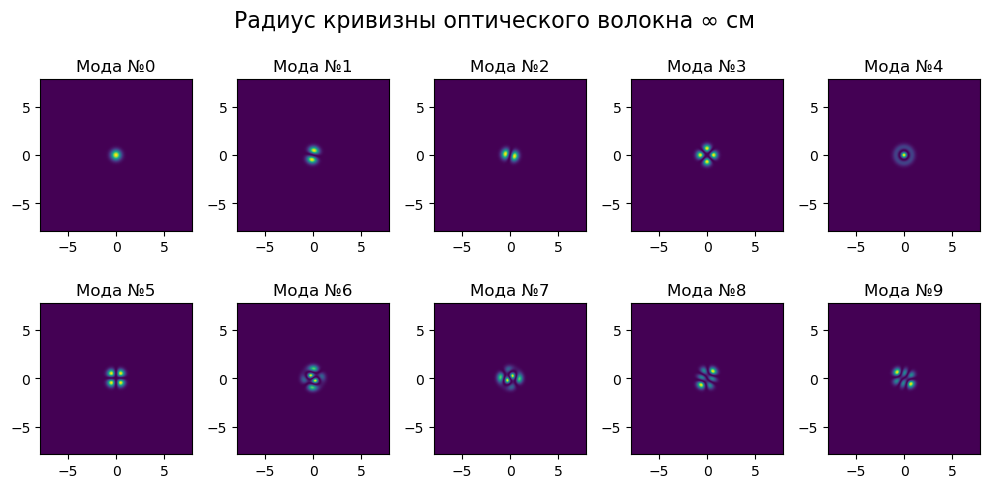

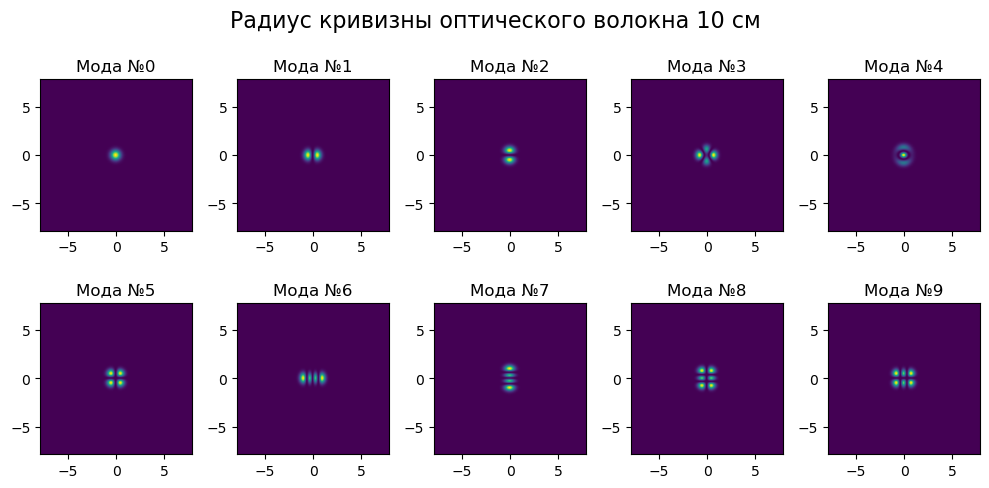

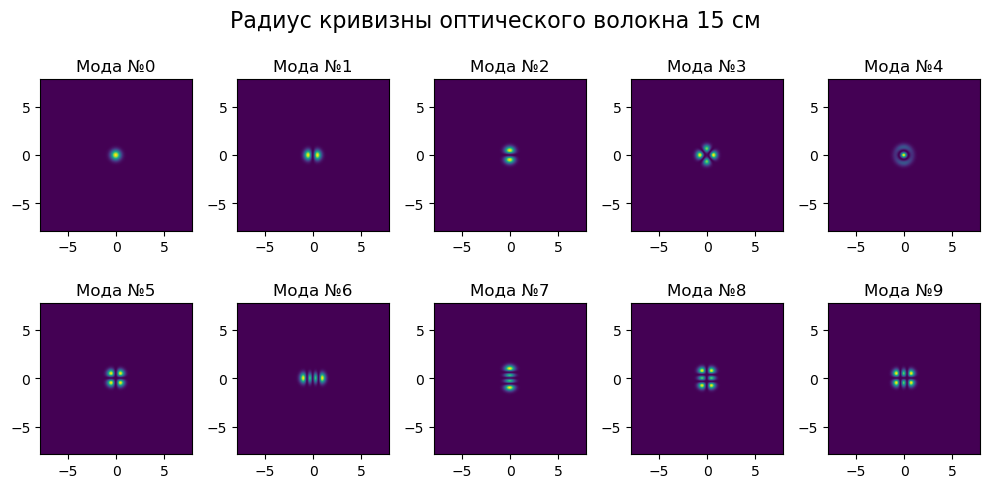

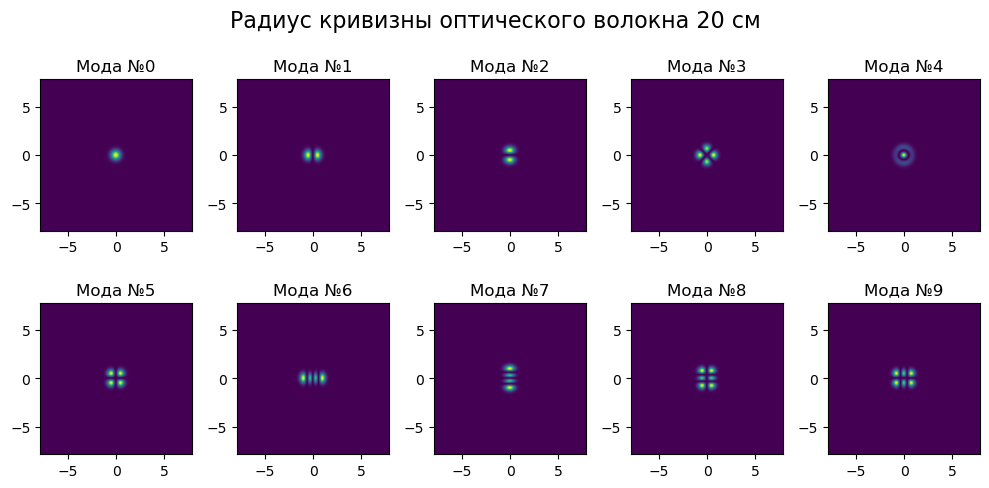

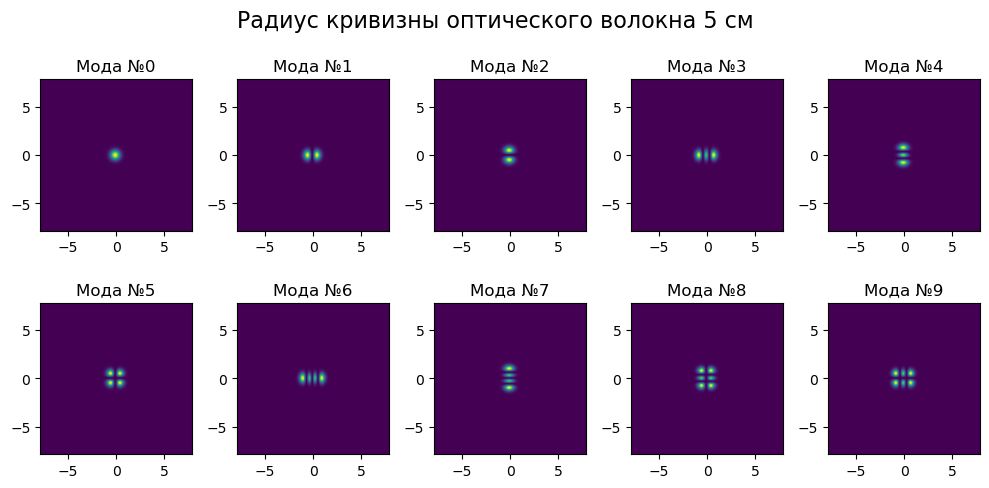

In [43]:
for c in modes:
    plot_modes(modes[c], np.arange(10), bounds, c)

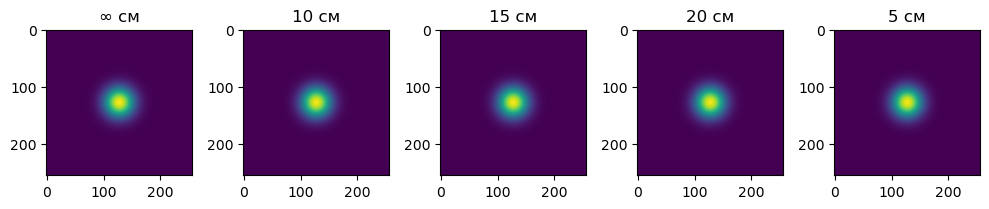

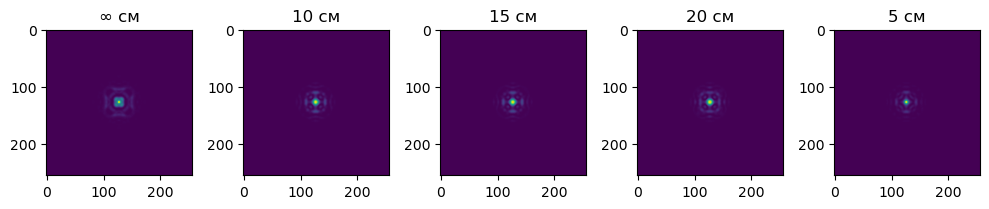

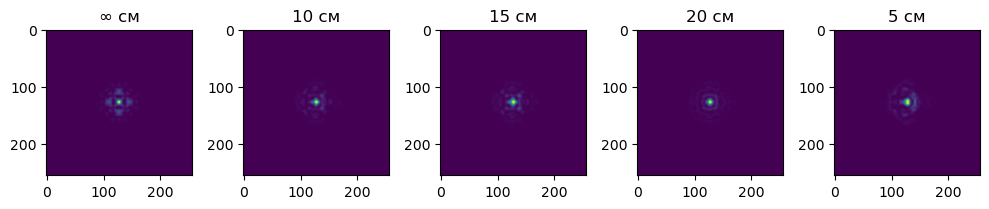

In [44]:
plot_profiles_by_curv(inputs)
plot_profiles_by_curv(outputs)
plot_profiles_by_curv(doutputs)

In [17]:
for c in outputs:
    print(np.corrcoef(doutputs[0].flatten(), doutputs[c].flatten())[0,1])

1.0
0.8364678414390303
0.8066704374740963
0.8416371449146344
0.8260081989364946


### Propagation test

In [18]:
wl = 0.632  # wavelength in microns
radius = 31.25  # in microns
n1 = 1.45
N = 100
# calculate the field on an area larger than the diameter of the fiber
area_size = 3.5 * radius
npoints = 2**8  # resolution of the window
fiber_len = 100 / um

ref = Beam2D(area_size, npoints, wl,
             init_field_gen=plane_wave,
             init_gen_args=(), use_gpu=True,
             complex_bits=64)

plane_data = {}
for c in modes:
    plane_data[c] = calc_inout(modes[c], ops[c], ref, fiber_len)

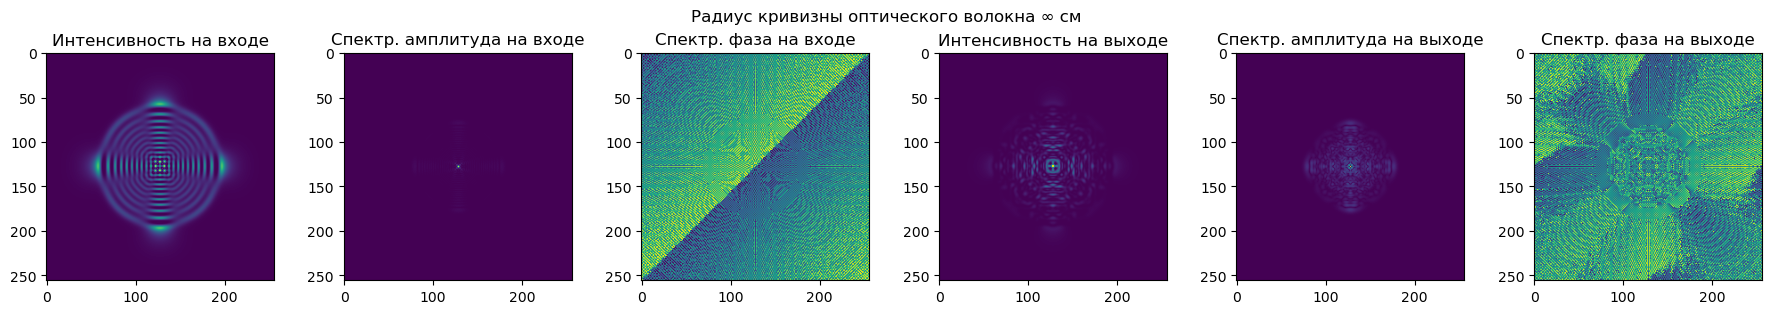

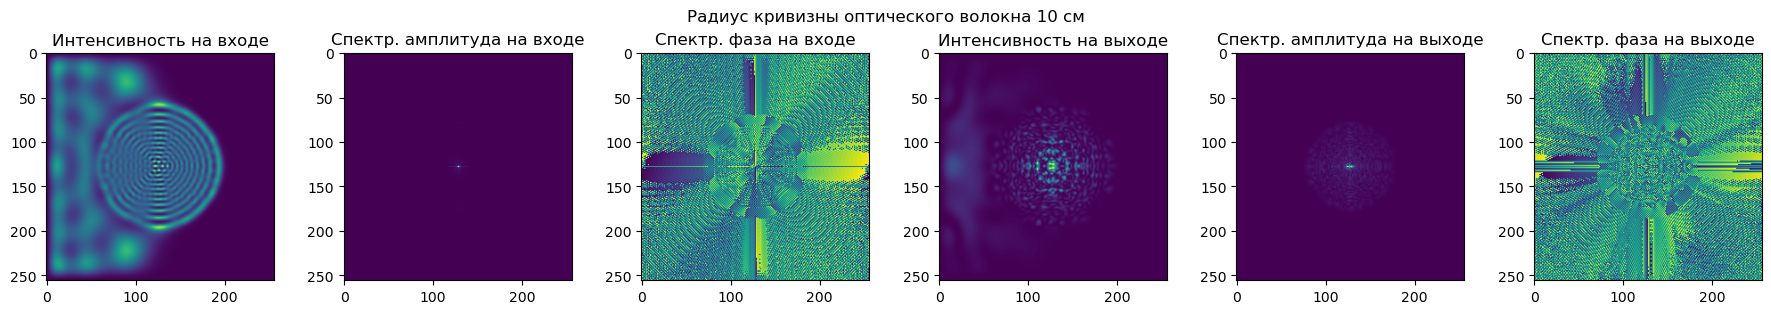

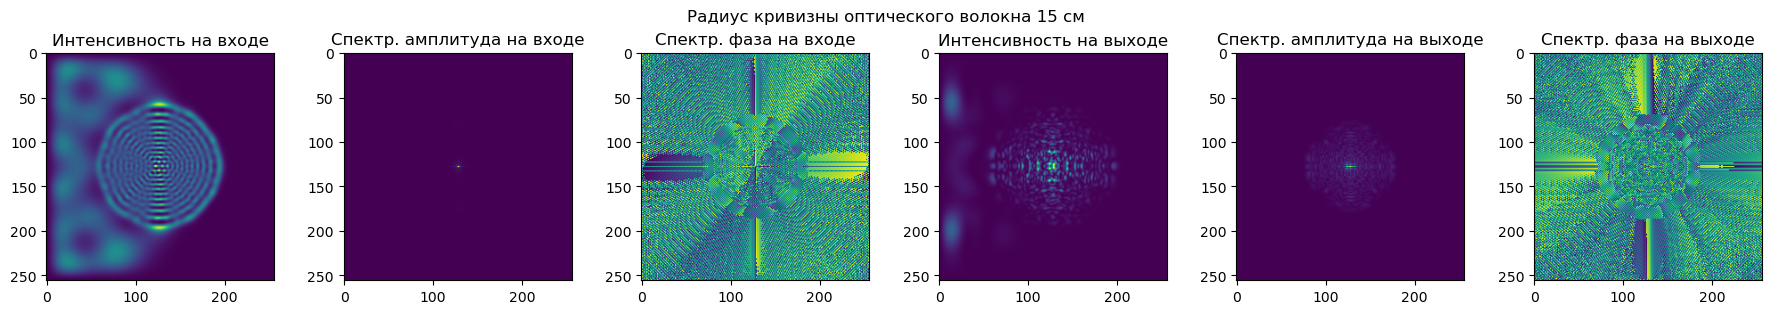

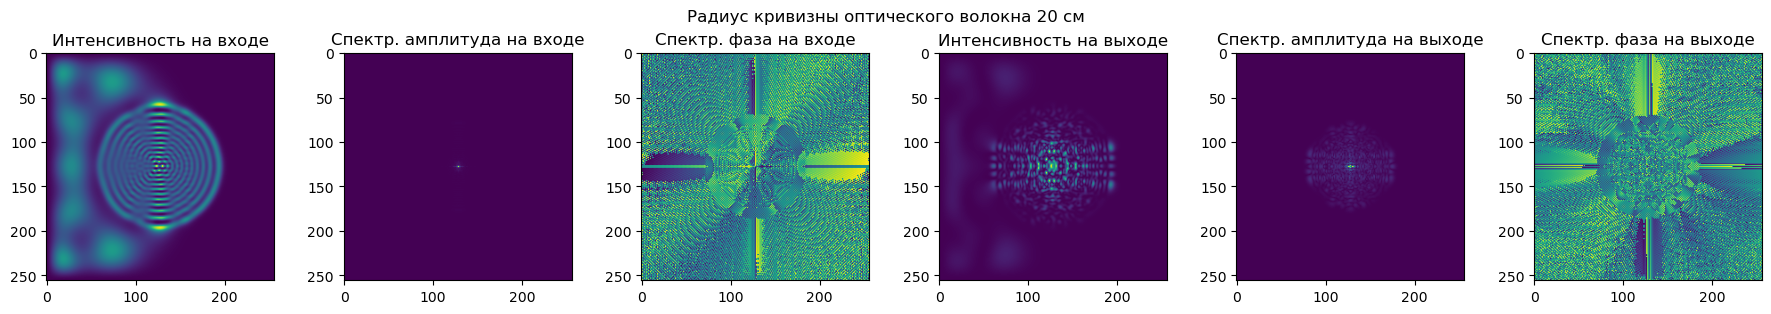

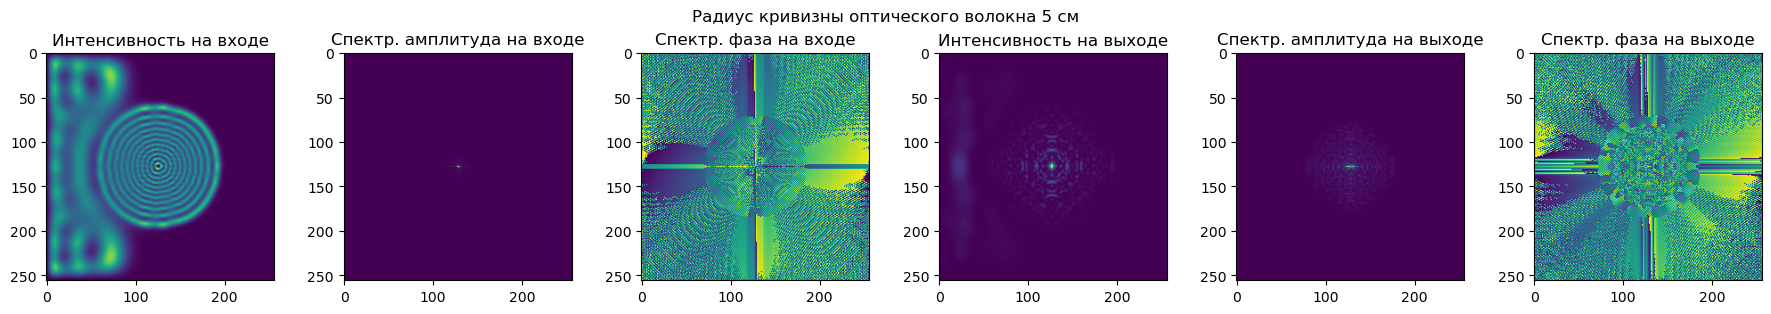

In [31]:
for c in plane_data:
    plot_inout_data(plane_data[c], c)

In [20]:
from lightprop2d import gaussian_beam, plane_wave

wl = 0.632  # wavelength in microns
radius = 31.25  # in microns
n1 = 1.45
N = 100
# calculate the field on an area larger than the diameter of the fiber
area_size = 3.5 * radius
npoints = 2**8  # resolution of the window
fiber_len = 100 / um

ref = Beam2D(area_size, npoints, wl,
             init_field_gen=gaussian_beam,
             init_gen_args=(1, 2.5), use_gpu=True,
             complex_bits=64)

gaussian_data = {}
for c in modes:
    gaussian_data[c] = calc_inout(modes[c], ops[c], ref, fiber_len)

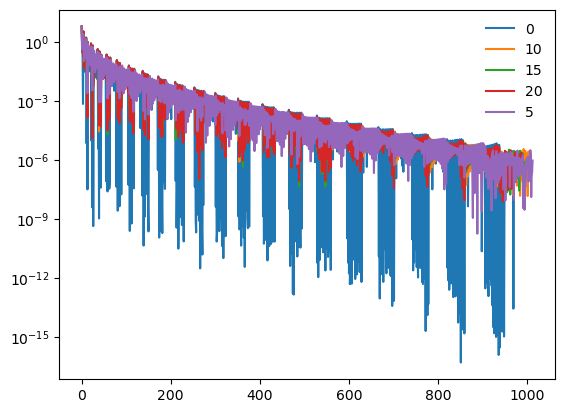

In [36]:
for c in gaussian_data:
    a = np.abs(gaussian_data[c][-2].get())
    plt.semilogy(a, label=c)
plt.legend(frameon=False)
plt.show()

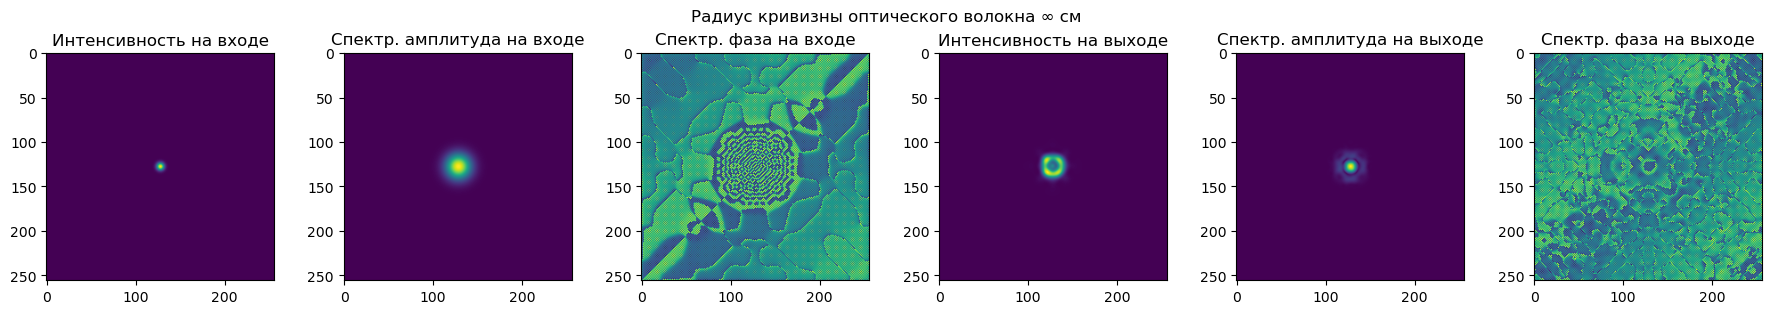

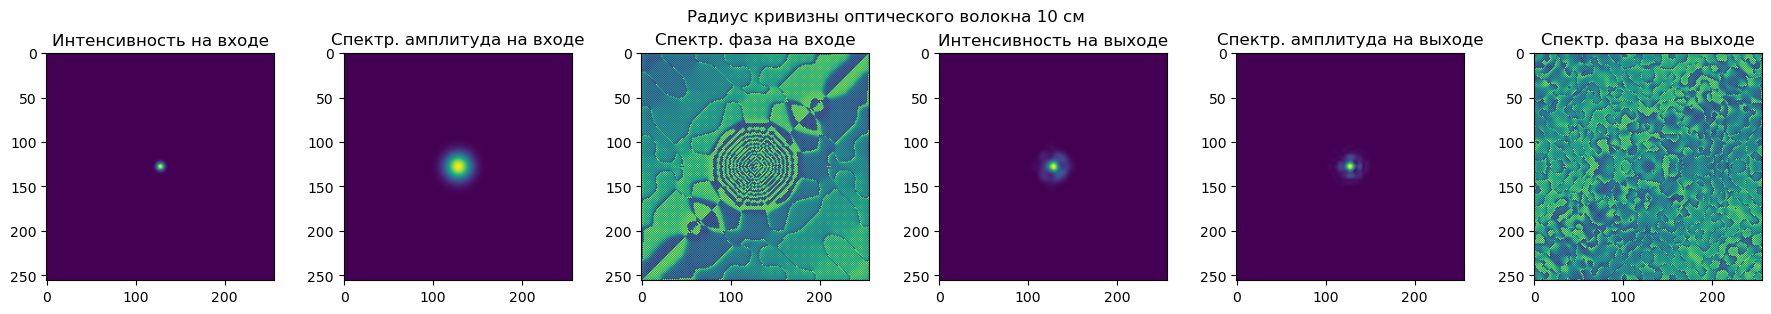

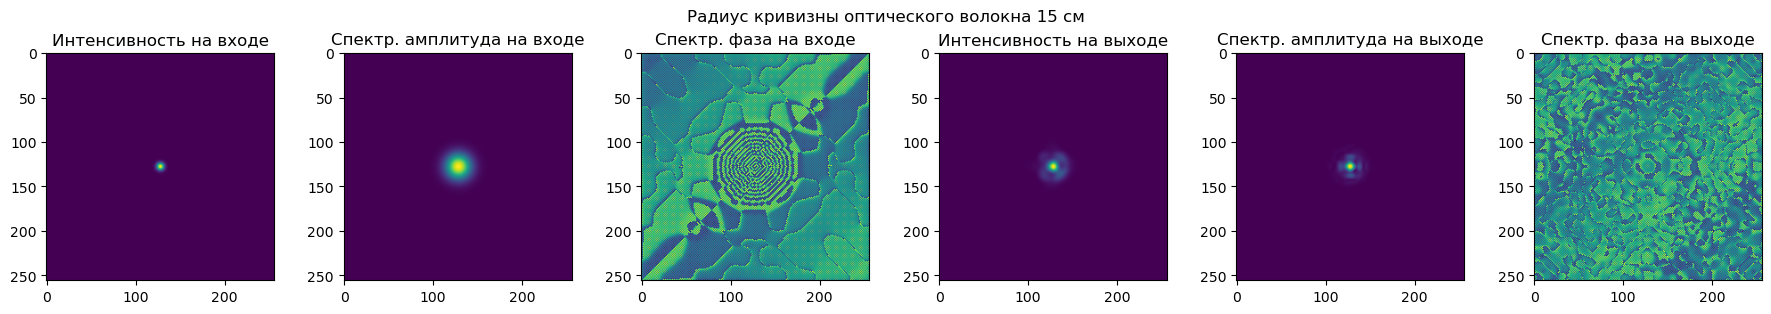

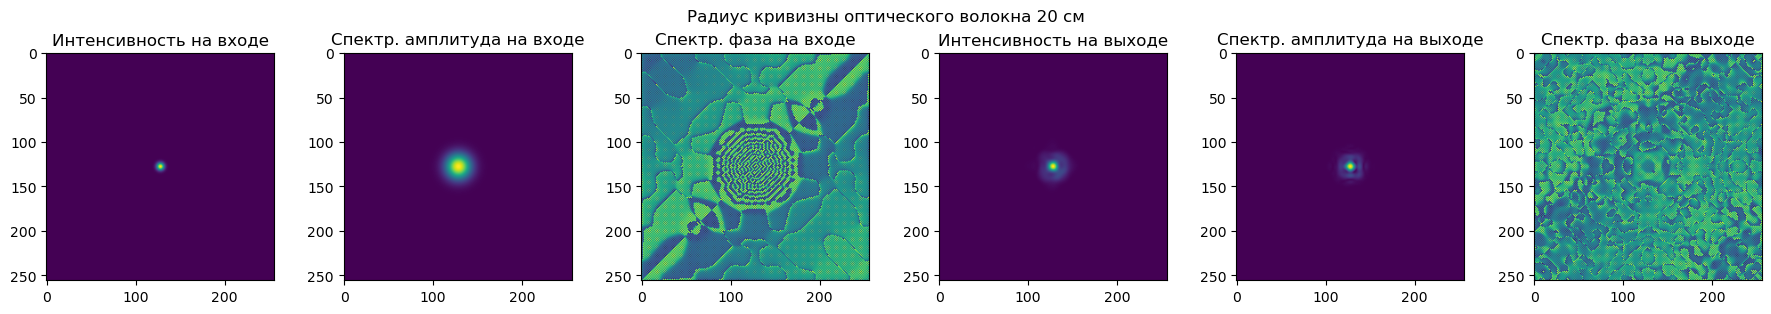

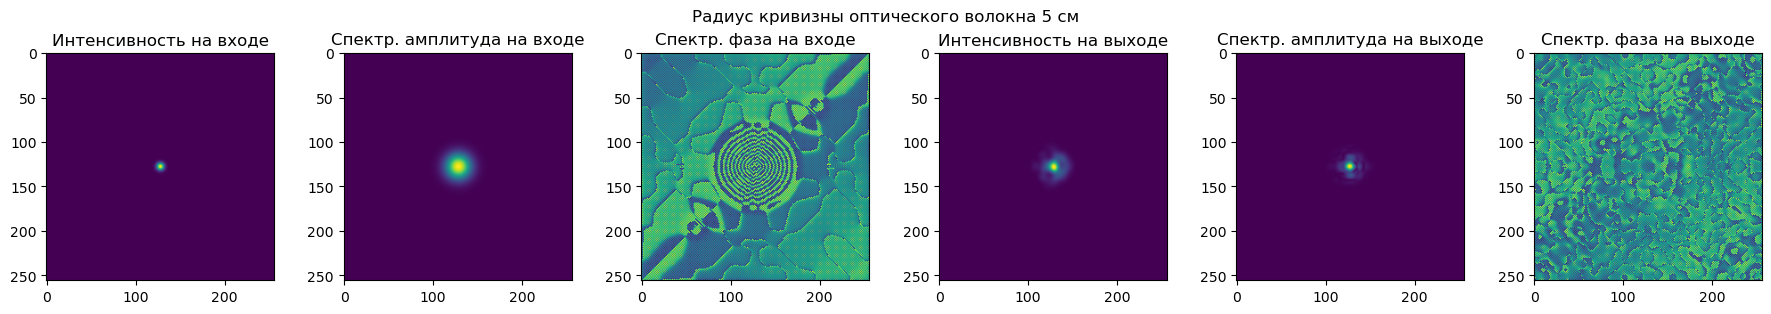

In [37]:
for c in gaussian_data:
    plot_inout_data(gaussian_data[c], c)